# Gibbs Sampling for the Uninitiated with Python 

The tutorial paper 
[Gibbs Sampling for the Uninitiated](https://www.umiacs.umd.edu/~resnik/pubs/LAMP-TR-153.pdf)
by Resnik and Hardisty is a masterpiece of exposition.  Their main example provides an amazingly 
clear description of how to build a Gibbs sampler for the very simple Naı̈ve Bayes probabilistic model. In this post I will implement that sampler in Python and exercise the implementation with a simulated text classification problem. To make things as easy to follow as possible, I'll ignore optimizing the code.  In a follow-up post I'll discuss optimization.

The diagram below illustrates the problem to be solved.  There is a collection documents, some with labels and 
some without.  The goal is to predict the labels for the unlabelled documents based on those we do observe.

![Graphical Model](https://ai2-s2-public.s3.amazonaws.com/figures/2016-11-01/fc024fbdc59c3b5e708268b29e00cebaf9593875/8-Figure4-1.png)

## State space and initialization

Since the latent variable $\pi$ can be integrated out (see $\S$2.4.3 of the paper), the state of the model at an
interation step is determined by the current values for the predicted labels $\bf L$, 
the topics $\bf \theta_0$ and $\bf \theta_1$, for each word $i$, the number of times, $N_{x,i}$, 
it occurs in the set of all documents labeled $x$, the number of documents labelled $0$, $C_0$, and 
the number of documents labelled $1$, $C_1$.  In the code below, this state will be represented as a dictionary
with the following keys: 'L' for the predicted labels, 'theta' for the topics, 'cnts' for word counts and 'C' 
for document counts.

How to initialize our sampler is described in at the end of $\S$2.3 of the paper:
1. Pick a value $\pi$ by sampling from the Beta($\gamma_{\pi1}$, $\gamma_{\pi0}$) distribution. 
2. Then, for each $j$, flip a coin with success probability $\pi$, and assign the label $L_j$ of document 
   $j$ based on the outcome of the coin flip.
3. Pick values for $\theta_0$ and $\theta_1$ by sampling from Dirichlet($\gamma_{\theta}$).

In [1]:
import numpy as np
from numpy.random import beta, binomial, dirichlet

def sample_labels(J, gamma_pi):
    pi = beta(gamma_pi[0], gamma_pi[1])
    return binomial(1, pi, J)

def initialize(W, labels, gamma_pi, gamma_theta):
    N = len(W)
    M = len(labels)
    V = len(gamma_theta)

    L = sample_labels(N - M, gamma_pi)
    theta = dirichlet(gamma_theta, 2)

    C = np.zeros((2,))
    C += gamma_pi
    cnts = np.zeros((2, V))
    cnts += gamma_theta
    
    for d, l in zip(W, labels.tolist() + L.tolist()):
        for i, c in d: cnts[l][i] += c
        C[l] += 1

    return {'C':C, 'N':cnts, 'L':L, 'theta':theta}

## The update step

In [8]:
def update(state, X):
    C = state['C']
    N = state['N']
    L = state['L']
    theta = state['theta']
    # Update the labels for all documents:
    for j, l in enumerate(L):
        # Drop document j from the corpus:
        for i, c in X[j]: N[l][i] -= c
        C[l] -= 1  
        # Compute the conditional probability that L[j] = 1:  
        if C[0] == 1: pi = 1.0
        elif C[1] == 1 <= 0: pi = 0.0 
        else:
            # compute the product of probabilities (sum of logs)
            d = np.sum(C) - 1
            v0 = np.log((C[0] - 1.0) / d)
            v1 = np.log((C[1] - 1.0) / d)
            for i, c in X[j]:
                v0 += c * np.log(theta[0,i])
                v1 += c * np.log(theta[1,i])
            m = max(v0, v1)
            v0 = np.exp(v0 - m)
            v1 = np.exp(v1 - m)
            pi = v1 / (v0 + v1)
        # Sample the new label from the conditional probability:
        l = binomial(1, pi)
        L[j] = l
        # Add document j back into the corpus:
        C[l] += 1
        for i, c in X[j]: N[l][i] += c
    #print('--->>>', np.min(cnts[0]), np.min(cnts[1]))
    # Update the topics:
    theta[0] = dirichlet(N[0])
    theta[1] = dirichlet(N[1])

## Running the Sampler

In [9]:
def run_sampler(W, labels, iterations, gamma_pi, gamma_theta):
    state = initialize(W, labels, gamma_pi, gamma_theta)
    X = W[len(labels):]
    for t in range(iterations): update(state, X)
    return state['L']

## Testing the Sampler

In [10]:
from numpy.random import multinomial, poisson

def generate_data(N, gamma_pi, gamma_theta, lmbda):
    labels = sample_labels(N, gamma_pi)
    theta = dirichlet(gamma_theta, 2)
    W = []
    for l in labels:
        R = poisson(lmbda)
        doc = multinomial(R, theta[l])
        W.append({(i, c) for i,c in enumerate(doc) if c > 0})
    return W, labels

In [11]:
def compute_accuracy(L_true, L_predicted):
    correct = 0
    for i, l in enumerate(L_predicted):
        if L_true[i] == l: correct += 1
    accuracy = float(correct)/len(L_predicted)
    return accuracy

In [12]:
def run_simulation(V, N, gamma_pi, gamma_theta, lmbda):
    W, labels = generate_data(N, gamma_pi, gamma_theta, lmbda)
    iterations = 100
    n = int(N * 0.8)
    labels_observed = labels[:n]
    labels_unobserved = labels[n:]
    
    L = run_sampler(W, labels_observed, iterations, gamma_pi, gamma_theta)
    return compute_accuracy(labels_unobserved, L)

Accuracy results: 0.850, 0.900, 0.800, 0.938, 0.950, 0.963, 0.938, 0.863, 0.738, 0.912
Average accuracy = 0.885


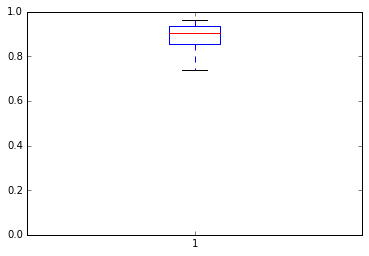

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

V = 10000
N = 400
gamma_pi = (1, 1)
gamma_theta = [1] * V
lmbda = 25

results = []
cnt = 0
while cnt < 10:
    accuracy = run_simulation(V, N, gamma_pi, gamma_theta, lmbda)
    results.append(accuracy)
    cnt += 1
    
print("Accuracy results: %s" % ", ".join("%0.3f" % x for x in results))
print("Average accuracy = %0.3f" % np.average(results))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0,1])
plt.boxplot(results);